## Load the Data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import GloVe
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
from utils import TextEmotionDataset

In [3]:
import os
import pickle

# Define the base path relative to the notebook's location
base_path = os.getcwd() 

# Paths to your files
tokenizer_path = os.path.join(base_path, 'tokenizer_pytorch.pkl')
processed_data_path = os.path.join(base_path, 'processed_data_pytorch.pkl')
label_encoder_path = os.path.join(base_path, 'label_encoder_pytorch.pkl')

# Load the tokenizer to get the vocabulary size
with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)

# Load the processed data
with open(processed_data_path, 'rb') as file:
    X_train_pad, X_val_pad, X_test_pad, y_train, y_val, y_test, max_seq_length = pickle.load(file)

# Load the label encoder
with open(label_encoder_path, 'rb') as file:
    label_encoder = pickle.load(file)

# Create datasets and dataloaders for training, validation, and testing
train_dataset = TextEmotionDataset(X_train_pad, y_train)
val_dataset = TextEmotionDataset(X_val_pad, y_val)  # Assuming you have a validation dataset
test_dataset = TextEmotionDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Assuming the same batch size as train_loader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Define the GloVe Embeddings

In [4]:
# GloVe embeddings
vocab_size = len(tokenizer.word_index) + 1
glove = GloVe(name='6B', dim=100)
embedding_matrix = torch.zeros((vocab_size, glove.dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = glove.vectors[glove.stoi[word]] if word in glove.stoi else torch.randn(glove.dim)
    embedding_matrix[index] = embedding_vector

## Define and Instantiate the Model

In [5]:
class EnhancedRNNModel(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, pretrained_embeddings, drop_prob=0.5):
        super(EnhancedRNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        # Apply dropout only if n_layers > 1
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob if n_layers > 1 else 0, 
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        soft_out = self.softmax(out)
        return soft_out

# Instantiate the model with the embedding matrix
model = EnhancedRNNModel(
    vocab_size, 
    len(label_encoder.classes_), 
    100,  # embedding dimension
    256,  # hidden dimension
    2,    # number of LSTM layers
    embedding_matrix  # pretrained GloVe embeddings
)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train the Model

In [5]:
import torch.nn as nn

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, grad_clip=5.0, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            total_train_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                output = model(inputs)
                val_loss = criterion(output, labels).item()
                total_val_loss += val_loss

                _, predicted = torch.max(output, 1)
                total_val_correct += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_accuracy = total_val_correct / total_val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/bi_lstm_emo.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, grad_clip=5.0, patience=3)

/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/emo2019/utils.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)


Epoch 1/10 - Train Loss: 0.4687, Train Accuracy: 0.8161, Val Loss: 0.2861, Val Accuracy: 0.8971
Epoch 2/10 - Train Loss: 0.2435, Train Accuracy: 0.9143, Val Loss: 0.2584, Val Accuracy: 0.9080
Epoch 3/10 - Train Loss: 0.1632, Train Accuracy: 0.9441, Val Loss: 0.2689, Val Accuracy: 0.9063
Epoch 4/10 - Train Loss: 0.1132, Train Accuracy: 0.9640, Val Loss: 0.2902, Val Accuracy: 0.9109
Epoch 5/10 - Train Loss: 0.0873, Train Accuracy: 0.9726, Val Loss: 0.3047, Val Accuracy: 0.9139
Early stopping triggered


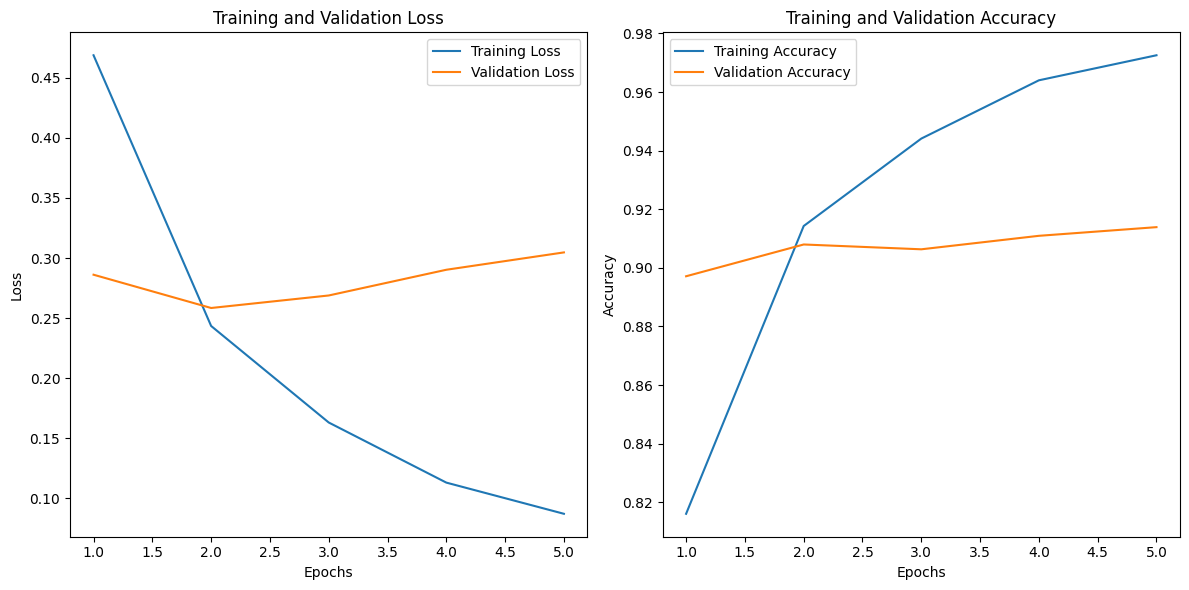

In [6]:
import matplotlib.pyplot as plt

# Plotting
epochs_range = range(1, len(train_losses) + 1)

# Plot for loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate Model

In [8]:
# Load the best model and evaluate on the validation and test sets
model.load_state_dict(torch.load('/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/bi_lstm_emo.pth'))

def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            output = model(inputs)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return classification_report(true_labels, all_preds, target_names=label_encoder.classes_)

# Evaluate the model on the validation set
val_report = evaluate_model(model, val_loader)
print("Validation Report:")
print(val_report)

# Evaluate the model on the test set
test_report = evaluate_model(model, test_loader)
print("Test Report:")
print(test_report)

/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/emo2019/utils.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)


Validation Report:
              precision    recall  f1-score   support

       angry       0.95      0.88      0.91      1149
       happy       0.95      0.91      0.93       857
         sad       0.84      0.94      0.89      1037

    accuracy                           0.91      3043
   macro avg       0.91      0.91      0.91      3043
weighted avg       0.91      0.91      0.91      3043



/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/emo2019/utils.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)


Test Report:
              precision    recall  f1-score   support

       angry       0.91      0.87      0.89       298
       happy       0.94      0.89      0.92       284
         sad       0.81      0.89      0.85       250

    accuracy                           0.89       832
   macro avg       0.89      0.89      0.89       832
weighted avg       0.89      0.89      0.89       832

